In [1]:
import pathlib
project_path = pathlib.Path().resolve().parent.parent
paths = []

import sys
path = project_path.joinpath("benchmark/third_party/bench-mr/python").as_posix()
if path not in sys.path:
    sys.path.append(path)

import os
os.environ["MPB_BINARY"] = "./benchmark"
os.environ["MPB_PYTHON_BINARY"] = "../../../../scripts/run_bench_mr.py"
os.environ["MPB_BINARY_DIR"] = "/home/mikhail/research/pytorch-motion-planner/benchmark/third_party/bench-mr/bin"
os.environ["PYTHONPATH"] = "../../../../build/benchmark:" + project_path.as_posix()

scenario_path = project_path.joinpath("benchmark/third_party/bench-mr/bin/moving_ai_scenarios")
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['pdf.fonttype'] = 42

from plot_env import plot_env
import json
from plot_env import plot_env, plot_env_options
from plot_trajectory import plot_trajectory, plot_nodes, plot_trajectory_options
from color import get_color, get_colors
import matplotlib.pyplot as plt
from mpb import MPB, MultipleMPB
from plot_stats import plot_planner_stats

%config InlineBackend.figure_format='retina'

# Run one experiment

In [2]:
m = MPB()
m["benchmark.moving_ai.active"] = True
m["benchmark.moving_ai.create_border"] = False
i = -3
m["benchmark.moving_ai.start"] = i
m["benchmark.moving_ai.end"] = i + 1
m["benchmark.moving_ai.scenario"] = scenario_path.joinpath("Berlin_0_256.map.scen").as_posix() 

m["max_planning_time"] = 60
m["benchmark.planning"]['constrained_onf_planner'] = True
m["steer.car_turning_radius"] = 2
m["sbpl.scaling"] = 1
# m.set_planners(['constrained_onf_planner', 'bfmt', 'cforest', 'prm', 'prm_star', 'informed_rrt_star', 'sbpl_mha'])
# m.set_planners(['constrained_onf_planner', 'informed_rrt_star', 'sbpl_mha'])
m.set_planners(['constrained_onf_planner'])
m.run(id="movingai_test_astar", runs=1)

Running MPB with ID movingai_test_astar (log file at movingai_test_astar.log)...


0

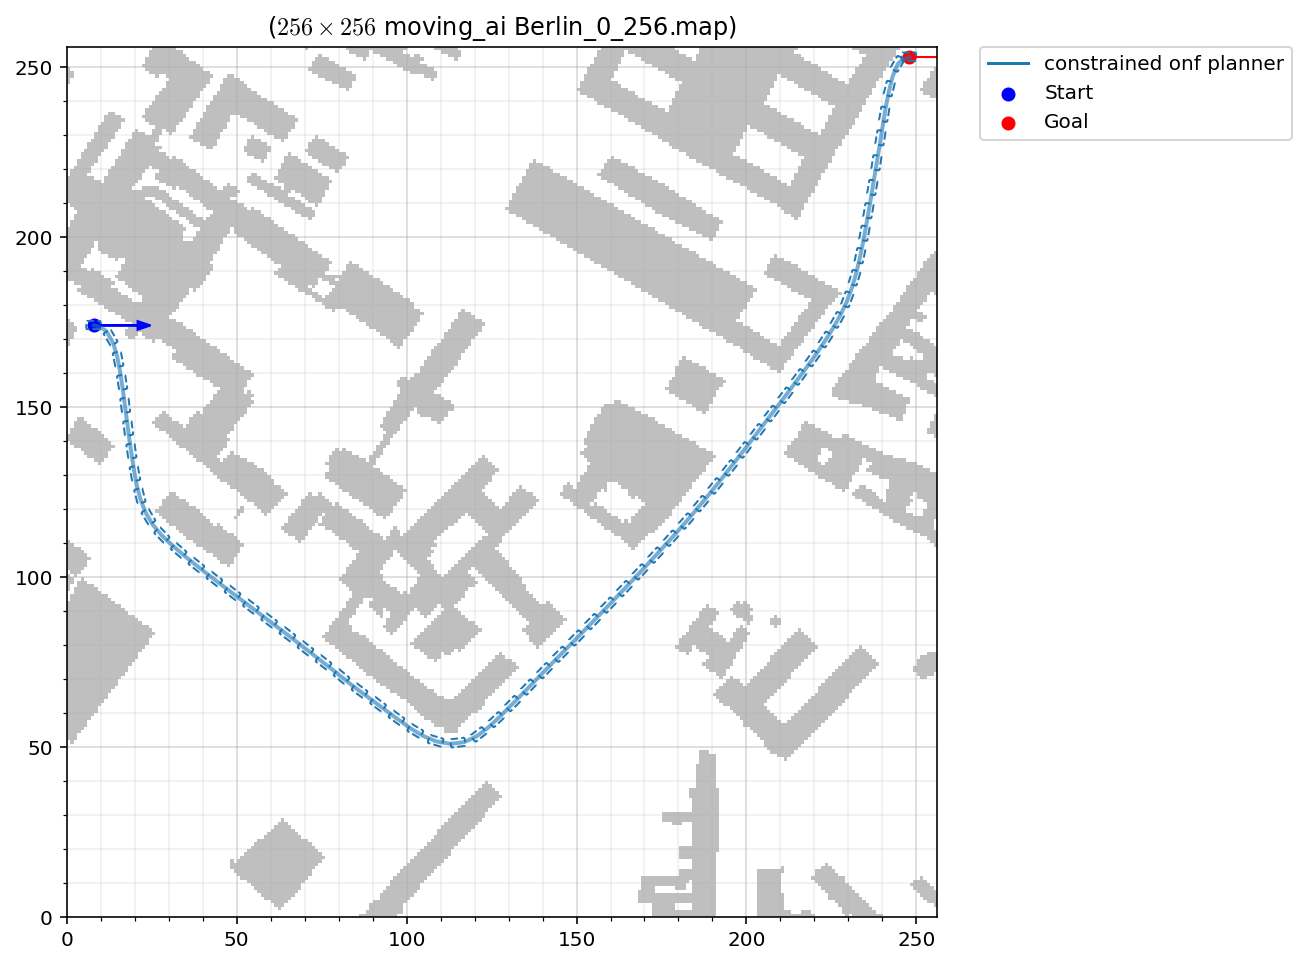

In [3]:
m.visualize_trajectories(draw_start_goal_thetas=True,
                         plot_every_nth_polygon=8,
                         fig_width=8,
                         fig_height=8,
                         silence=True,
                         save_file="plots/movingai_experiment.pdf",
                         num_colors=10)

In [6]:
path = project_path.as_posix()
if path not in sys.path:
    sys.path.append(path)
    
path = project_path.joinpath("build/benchmark").as_posix()
if path not in sys.path:
    sys.path.append(path)
os.chdir(project_path.joinpath("benchmark/third_party/bench-mr/bin").as_posix())
from neural_field_optimal_planner.benchmark_adapter import BenchmarkAdapter
from neural_field_optimal_planner.benchmark_adapter.benchmark_collision_checker import BenchmarkCollisionChecker
from neural_field_optimal_planner.utils.position2 import Position2
from neural_field_optimal_planner.astar.jps import JPS
import numpy as np

ROS is not sourced. To enable ROS features, please source it


In [7]:
config_path = project_path.joinpath("notebooks/benchmark/movingai_test_astar_config.json").as_posix()
benchmark = BenchmarkAdapter(config_path)
collision_checker = BenchmarkCollisionChecker(benchmark, benchmark.bounds())

In [8]:
goal = benchmark.goal().as_vec()
start = benchmark.start().as_vec()
resolution = 0.5

In [9]:
boundaries = collision_checker.get_boundaries()
x_cells = int((boundaries[1] - boundaries[0]) // resolution) + 1
y_cells = int((boundaries[3] - boundaries[2]) // resolution) + 1
start_x_cell = int((start[0] - boundaries[0]) // resolution)
start_y_cell = int((start[1] - boundaries[2]) // resolution)
goal_x_cell = int((goal[0] - boundaries[0]) // resolution)
goal_y_cell = int((goal[1] - boundaries[2]) // resolution)
x, y = np.meshgrid(range(x_cells), range(y_cells))
x = x.reshape(-1) * resolution + resolution / 2 + boundaries[0]
y = y.reshape(-1) * resolution + resolution / 2 + boundaries[2]
positions = Position2(x, y, np.zeros_like(x) + np.pi / 2)
collisions = collision_checker.check_collision(positions)
matrix = collisions.reshape(x_cells, y_cells)
# planner = JPS(matrix, jps=False)
# path = planner.find_path((start_x_cell, start_y_cell), (goal_x_cell, goal_y_cell))
# path[:, 0] = path[:, 0] * resolution + resolution / 2 + boundaries[0]
# path[:, 1] = path[:, 1] * resolution + resolution / 2 + boundaries[2]
# return path

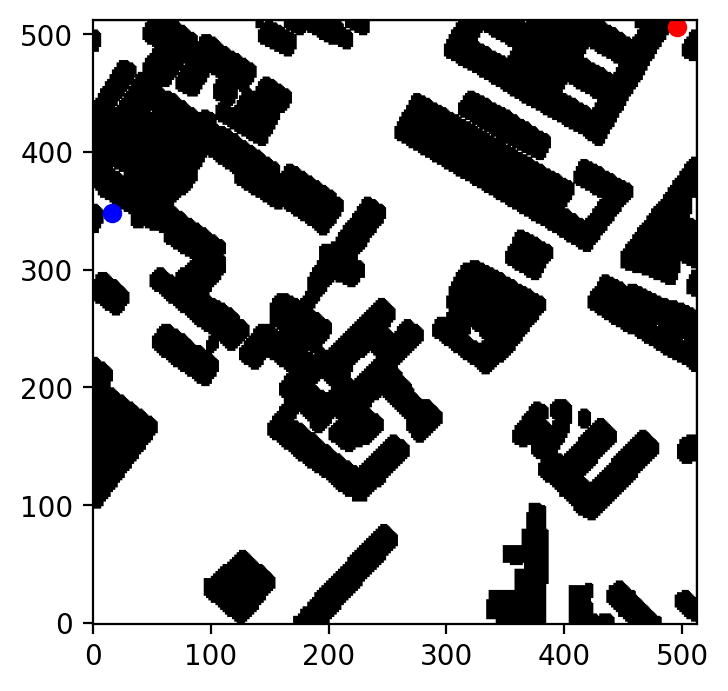

In [10]:
plt.figure(dpi=100)
plt.scatter([start_x_cell], [start_y_cell], color="blue")
plt.scatter([goal_x_cell], [goal_y_cell], color="red")
plt.imshow(1 - matrix, cmap="gray", origin="low")

In [11]:
planner = JPS(matrix, jps=False)
path = planner.find_path((start_y_cell, start_x_cell), (goal_y_cell, goal_x_cell))

solution found with: 48918 nodes expanded.
with path length: 700


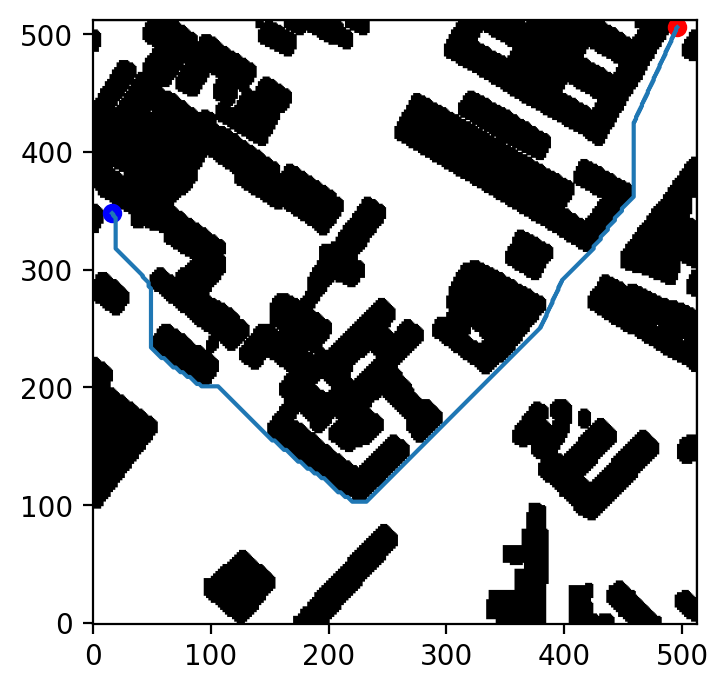

In [12]:
plt.figure(dpi=100)
plt.scatter([start_x_cell], [start_y_cell], color="blue")
plt.scatter([goal_x_cell], [goal_y_cell], color="red")
plt.plot(path[:, 1], path[:, 0])
plt.imshow(1 - matrix, cmap="gray", origin="low")